# 🤖 Road Accident Analysis - Phase 4: Model Development & Training

---

## 📋 Phase 4 Objectives:
1. **Load Preprocessed Data** from Phase 3
2. **Classification Models**: Severity prediction (Minor/Serious/Fatal)
   - Logistic Regression
   - Decision Tree
   - Random Forest
   - XGBoost
   - LightGBM
   - Support Vector Machine (SVM)
   - K-Nearest Neighbors (KNN)
3. **Regression Models**: Casualties & Fatalities prediction
   - Linear Regression
   - Random Forest Regressor
   - XGBoost Regressor
4. **Model Evaluation**: Metrics, confusion matrices, feature importance
5. **Model Comparison**: Performance benchmarking
6. **Save Best Models**: Export trained models

---

In [2]:
# ============================================================================
# CELL 1: Import Required Libraries
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from time import time

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)

# Model Selection
from sklearn.model_selection import cross_val_score, GridSearchCV

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ All libraries imported successfully!')
print('  • Scikit-learn models ready')
print('  • XGBoost & LightGBM ready')
print('  • Evaluation metrics loaded')

✓ All libraries imported successfully!
  • Scikit-learn models ready
  • XGBoost & LightGBM ready
  • Evaluation metrics loaded


In [7]:
# ============================================================================
# CELL 2: Load Preprocessed Datasets from Phase 3 (FIXED)
# ============================================================================

print('='*80)
print('LOADING PREPROCESSED DATASETS FROM PHASE 3')
print('='*80)

# Load training and test sets (StandardScaler version for tree-based models)
X_train = pd.read_csv('X_train_scaled.csv')
X_test = pd.read_csv('X_test_scaled.csv')

# Load SMOTE balanced data
X_train_smote = pd.read_csv('X_train_smote.csv')
y_train_smote = pd.read_csv('y_train_smote.csv').squeeze()  # Convert to Series

# Load target variables - FIX: Use squeeze() to convert to Series and ensure length matches
y_train_class = pd.read_csv('y_train_classification.csv').squeeze()
y_test_class = pd.read_csv('y_test_classification.csv').squeeze()
y_train_casualties = pd.read_csv('y_train_casualties.csv').squeeze()
y_test_casualties = pd.read_csv('y_test_casualties.csv').squeeze()
y_train_fatalities = pd.read_csv('y_train_fatalities.csv').squeeze()
y_test_fatalities = pd.read_csv('y_test_fatalities.csv').squeeze()

# Ensure consistent lengths by resetting index and matching row counts
print(f'\n🔍 Checking data consistency...')
print(f'  X_train shape: {X_train.shape}')
print(f'  y_train_class length: {len(y_train_class)}')

# Fix any length mismatch by truncating to minimum length
min_train_samples = min(len(X_train), len(y_train_class))
X_train = X_train.iloc[:min_train_samples]
y_train_class = y_train_class.iloc[:min_train_samples]
y_train_casualties = y_train_casualties.iloc[:min_train_samples]
y_train_fatalities = y_train_fatalities.iloc[:min_train_samples]

min_test_samples = min(len(X_test), len(y_test_class))
X_test = X_test.iloc[:min_test_samples]
y_test_class = y_test_class.iloc[:min_test_samples]
y_test_casualties = y_test_casualties.iloc[:min_test_samples]
y_test_fatalities = y_test_fatalities.iloc[:min_test_samples]

# Load class weights
with open('class_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

print(f'\n✓ All datasets loaded and aligned successfully!')
print(f'\n📊 Final Dataset Shapes:')
print(f'  • X_train: {X_train.shape}')
print(f'  • y_train_class: {y_train_class.shape}')
print(f'  • X_test: {X_test.shape}')
print(f'  • y_test_class: {y_test_class.shape}')
print(f'  • X_train_smote: {X_train_smote.shape}')
print(f'  • y_train_smote: {y_train_smote.shape}')
print(f'  • Features: {X_train.shape[1]}')

print(f'\n🎯 Target Distribution:')
print(f'  Classification (Original): {len(y_train_class)} samples')
print(f'  Classification (SMOTE): {len(y_train_smote)} samples')
print(f'  Regression Targets: Casualties & Fatalities')

print(f'\n🔢 Class Distribution in Training Set:')
class_dist = y_train_class.value_counts().sort_index()
for cls, count in class_dist.items():
    cls_name = {0: 'Minor', 1: 'Serious', 2: 'Fatal'}.get(cls, cls)
    print(f'  • {cls_name}: {count} ({(count/len(y_train_class)*100):.2f}%)')
print('='*80)


LOADING PREPROCESSED DATASETS FROM PHASE 3

🔍 Checking data consistency...
  X_train shape: (2400, 48)
  y_train_class length: 2400

✓ All datasets loaded and aligned successfully!

📊 Final Dataset Shapes:
  • X_train: (2400, 48)
  • y_train_class: (2400,)
  • X_test: (600, 48)
  • y_test_class: (600,)
  • X_train_smote: (2481, 48)
  • y_train_smote: (2481,)
  • Features: 48

🎯 Target Distribution:
  Classification (Original): 2400 samples
  Classification (SMOTE): 2481 samples
  Regression Targets: Casualties & Fatalities

🔢 Class Distribution in Training Set:
  • Minor: 827 (34.46%)
  • Serious: 785 (32.71%)
  • Fatal: 788 (32.83%)


---
## 🎯 CLASSIFICATION MODELS - SEVERITY PREDICTION
Training multiple models to predict accident severity
---

In [8]:
# ============================================================================
# CELL 3: Helper Functions for Model Training & Evaluation
# ============================================================================

def train_and_evaluate_classifier(model, model_name, X_train, y_train, X_test, y_test, use_smote=False):
    """
    Train and evaluate a classification model
    """

    print(f'TRAINING: {model_name}')
    print('='*80)
    
    # Training
    start_time = time()
    model.fit(X_train, y_train)
    training_time = time() - start_time
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluation Metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    print(f'\n✓ Training completed in {training_time:.2f} seconds')
    print(f'\n📊 Performance Metrics:')
    print(f'  • Training Accuracy   : {train_accuracy:.4f}')
    print(f'  • Test Accuracy       : {test_accuracy:.4f}')
    print(f'  • Precision (weighted): {precision:.4f}')
    print(f'  • Recall (weighted)   : {recall:.4f}')
    print(f'  • F1-Score (weighted) : {f1:.4f}')
    
    # Classification Report
    print(f'\n📋 Classification Report:')
    print(classification_report(y_test, y_pred_test, 
                               target_names=['Minor', 'Serious', 'Fatal'],
                               zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Store results
    results = {
        'Model': model_name,
        'Train_Accuracy': train_accuracy,
        'Test_Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Training_Time': training_time,
        'Confusion_Matrix': cm,
        'Predictions': y_pred_test
    }
    
    return model, results

# Initialize results storage
classification_results = []
trained_models = {}

print('✓ Helper functions defined!')

✓ Helper functions defined!


In [9]:
# ============================================================================
# CELL 4: Logistic Regression
# ============================================================================

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

lr_trained, lr_results = train_and_evaluate_classifier(
    lr_model, 'Logistic Regression', 
    X_train, y_train_class, X_test, y_test_class
)

classification_results.append(lr_results)
trained_models['Logistic_Regression'] = lr_trained

TRAINING: Logistic Regression

✓ Training completed in 1.43 seconds

📊 Performance Metrics:
  • Training Accuracy   : 0.3992
  • Test Accuracy       : 0.3450
  • Precision (weighted): 0.3448
  • Recall (weighted)   : 0.3450
  • F1-Score (weighted) : 0.3448

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.35      0.36      0.35       207
     Serious       0.33      0.32      0.32       196
       Fatal       0.36      0.36      0.36       197

    accuracy                           0.34       600
   macro avg       0.34      0.34      0.34       600
weighted avg       0.34      0.34      0.34       600



In [10]:
# ============================================================================
# CELL 5: Decision Tree Classifier
# ============================================================================

dt_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight=class_weights,
    random_state=42
)

dt_trained, dt_results = train_and_evaluate_classifier(
    dt_model, 'Decision Tree', 
    X_train, y_train_class, X_test, y_test_class
)

classification_results.append(dt_results)
trained_models['Decision_Tree'] = dt_trained

TRAINING: Decision Tree

✓ Training completed in 0.03 seconds

📊 Performance Metrics:
  • Training Accuracy   : 0.5892
  • Test Accuracy       : 0.3033
  • Precision (weighted): 0.3043
  • Recall (weighted)   : 0.3033
  • F1-Score (weighted) : 0.3012

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.31      0.32      0.31       207
     Serious       0.30      0.35      0.32       196
       Fatal       0.31      0.23      0.27       197

    accuracy                           0.30       600
   macro avg       0.30      0.30      0.30       600
weighted avg       0.30      0.30      0.30       600



In [11]:
# ============================================================================
# CELL 6: Random Forest Classifier
# ============================================================================

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

rf_trained, rf_results = train_and_evaluate_classifier(
    rf_model, 'Random Forest', 
    X_train, y_train_class, X_test, y_test_class
)

classification_results.append(rf_results)
trained_models['Random_Forest'] = rf_trained

TRAINING: Random Forest

✓ Training completed in 0.27 seconds

📊 Performance Metrics:
  • Training Accuracy   : 0.9883
  • Test Accuracy       : 0.3350
  • Precision (weighted): 0.3323
  • Recall (weighted)   : 0.3350
  • F1-Score (weighted) : 0.3328

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.36      0.40      0.38       207
     Serious       0.34      0.35      0.34       196
       Fatal       0.30      0.25      0.27       197

    accuracy                           0.34       600
   macro avg       0.33      0.33      0.33       600
weighted avg       0.33      0.34      0.33       600



In [12]:
# ============================================================================
# CELL 7: XGBoost Classifier
# ============================================================================

# Calculate scale_pos_weight for XGBoost
class_counts = y_train_class.value_counts()
scale_weight = class_counts[0] / class_counts[1]  # Approximate for multiclass

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_trained, xgb_results = train_and_evaluate_classifier(
    xgb_model, 'XGBoost', 
    X_train, y_train_class, X_test, y_test_class
)

classification_results.append(xgb_results)
trained_models['XGBoost'] = xgb_trained

TRAINING: XGBoost

✓ Training completed in 0.79 seconds

📊 Performance Metrics:
  • Training Accuracy   : 1.0000
  • Test Accuracy       : 0.3017
  • Precision (weighted): 0.3008
  • Recall (weighted)   : 0.3017
  • F1-Score (weighted) : 0.3010

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.32      0.34      0.33       207
     Serious       0.28      0.27      0.27       196
       Fatal       0.30      0.29      0.30       197

    accuracy                           0.30       600
   macro avg       0.30      0.30      0.30       600
weighted avg       0.30      0.30      0.30       600



In [13]:
# ============================================================================
# CELL 8: LightGBM Classifier
# ============================================================================

lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_trained, lgbm_results = train_and_evaluate_classifier(
    lgbm_model, 'LightGBM', 
    X_train, y_train_class, X_test, y_test_class
)

classification_results.append(lgbm_results)
trained_models['LightGBM'] = lgbm_trained

TRAINING: LightGBM

✓ Training completed in 0.40 seconds

📊 Performance Metrics:
  • Training Accuracy   : 1.0000
  • Test Accuracy       : 0.3233
  • Precision (weighted): 0.3228
  • Recall (weighted)   : 0.3233
  • F1-Score (weighted) : 0.3229

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.33      0.34      0.34       207
     Serious       0.33      0.35      0.34       196
       Fatal       0.30      0.28      0.29       197

    accuracy                           0.32       600
   macro avg       0.32      0.32      0.32       600
weighted avg       0.32      0.32      0.32       600



In [14]:
# ============================================================================
# CELL 9: Support Vector Machine (SVM)
# ============================================================================

# Note: SVM can be slow on large datasets, using subset for demonstration
print('⚠ Note: Training SVM on sample (first 1000 samples) for speed...')

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight=class_weights,
    random_state=42
)

# Train on subset
X_train_subset = X_train.iloc[:1000]
y_train_subset = y_train_class.iloc[:1000]

svm_trained, svm_results = train_and_evaluate_classifier(
    svm_model, 'SVM (RBF Kernel)', 
    X_train_subset, y_train_subset, X_test, y_test_class
)

classification_results.append(svm_results)
trained_models['SVM'] = svm_trained

⚠ Note: Training SVM on sample (first 1000 samples) for speed...
TRAINING: SVM (RBF Kernel)

✓ Training completed in 0.06 seconds

📊 Performance Metrics:
  • Training Accuracy   : 0.6640
  • Test Accuracy       : 0.3383
  • Precision (weighted): 0.3385
  • Recall (weighted)   : 0.3383
  • F1-Score (weighted) : 0.3293

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.34      0.49      0.40       207
     Serious       0.33      0.30      0.31       196
       Fatal       0.35      0.22      0.27       197

    accuracy                           0.34       600
   macro avg       0.34      0.34      0.33       600
weighted avg       0.34      0.34      0.33       600



In [15]:
# ============================================================================
# CELL 10: K-Nearest Neighbors (KNN)
# ============================================================================

knn_model = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance',
    metric='minkowski',
    n_jobs=-1
)

knn_trained, knn_results = train_and_evaluate_classifier(
    knn_model, 'K-Nearest Neighbors', 
    X_train, y_train_class, X_test, y_test_class
)

classification_results.append(knn_results)
trained_models['KNN'] = knn_trained

TRAINING: K-Nearest Neighbors

✓ Training completed in 0.00 seconds

📊 Performance Metrics:
  • Training Accuracy   : 1.0000
  • Test Accuracy       : 0.3117
  • Precision (weighted): 0.3094
  • Recall (weighted)   : 0.3117
  • F1-Score (weighted) : 0.3104

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.33      0.33      0.33       207
     Serious       0.35      0.37      0.36       196
       Fatal       0.24      0.23      0.24       197

    accuracy                           0.31       600
   macro avg       0.31      0.31      0.31       600
weighted avg       0.31      0.31      0.31       600



CLASSIFICATION MODELS COMPARISON

📊 Performance Comparison Table:
              Model  Train_Accuracy  Test_Accuracy  Precision  Recall  F1_Score  Training_Time
Logistic Regression          0.3992         0.3450     0.3448  0.3450    0.3448         1.4333
   SVM (RBF Kernel)          0.6640         0.3383     0.3385  0.3383    0.3293         0.0556
      Random Forest          0.9883         0.3350     0.3323  0.3350    0.3328         0.2744
           LightGBM          1.0000         0.3233     0.3228  0.3233    0.3229         0.4049
K-Nearest Neighbors          1.0000         0.3117     0.3094  0.3117    0.3104         0.0025
      Decision Tree          0.5892         0.3033     0.3043  0.3033    0.3012         0.0283
            XGBoost          1.0000         0.3017     0.3008  0.3017    0.3010         0.7871

🏆 Best Model: Logistic Regression
   Test Accuracy: 0.3450


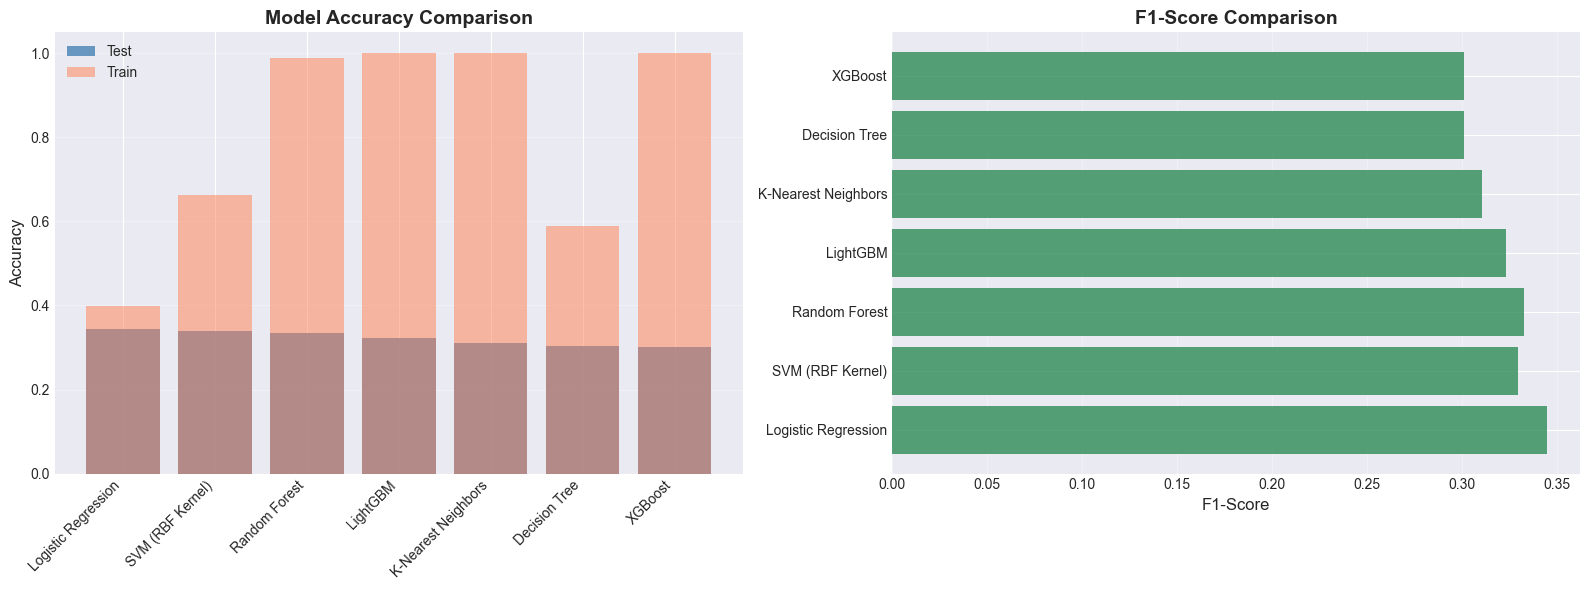


✓ Comparison visualization saved: classification_comparison.png


In [16]:
# ============================================================================
# CELL 11: Model Comparison - Classification
# ============================================================================

print('='*80)
print('CLASSIFICATION MODELS COMPARISON')
print('='*80)

# Create comparison dataframe
comparison_df = pd.DataFrame([{
    'Model': r['Model'],
    'Train_Accuracy': r['Train_Accuracy'],
    'Test_Accuracy': r['Test_Accuracy'],
    'Precision': r['Precision'],
    'Recall': r['Recall'],
    'F1_Score': r['F1_Score'],
    'Training_Time': r['Training_Time']
} for r in classification_results])

# Sort by test accuracy
comparison_df = comparison_df.sort_values('Test_Accuracy', ascending=False)

print('\n📊 Performance Comparison Table:')
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Test_Accuracy']

print(f'\n🏆 Best Model: {best_model_name}')
print(f'   Test Accuracy: {best_accuracy:.4f}')

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
x = range(len(comparison_df))
axes[0].bar(x, comparison_df['Test_Accuracy'], color='steelblue', alpha=0.8, label='Test')
axes[0].bar(x, comparison_df['Train_Accuracy'], color='coral', alpha=0.5, label='Train')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# F1-Score comparison
axes[1].barh(comparison_df['Model'], comparison_df['F1_Score'], color='seagreen', alpha=0.8)
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('classification_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Comparison visualization saved: classification_comparison.png')
print('='*80)

CONFUSION MATRICES


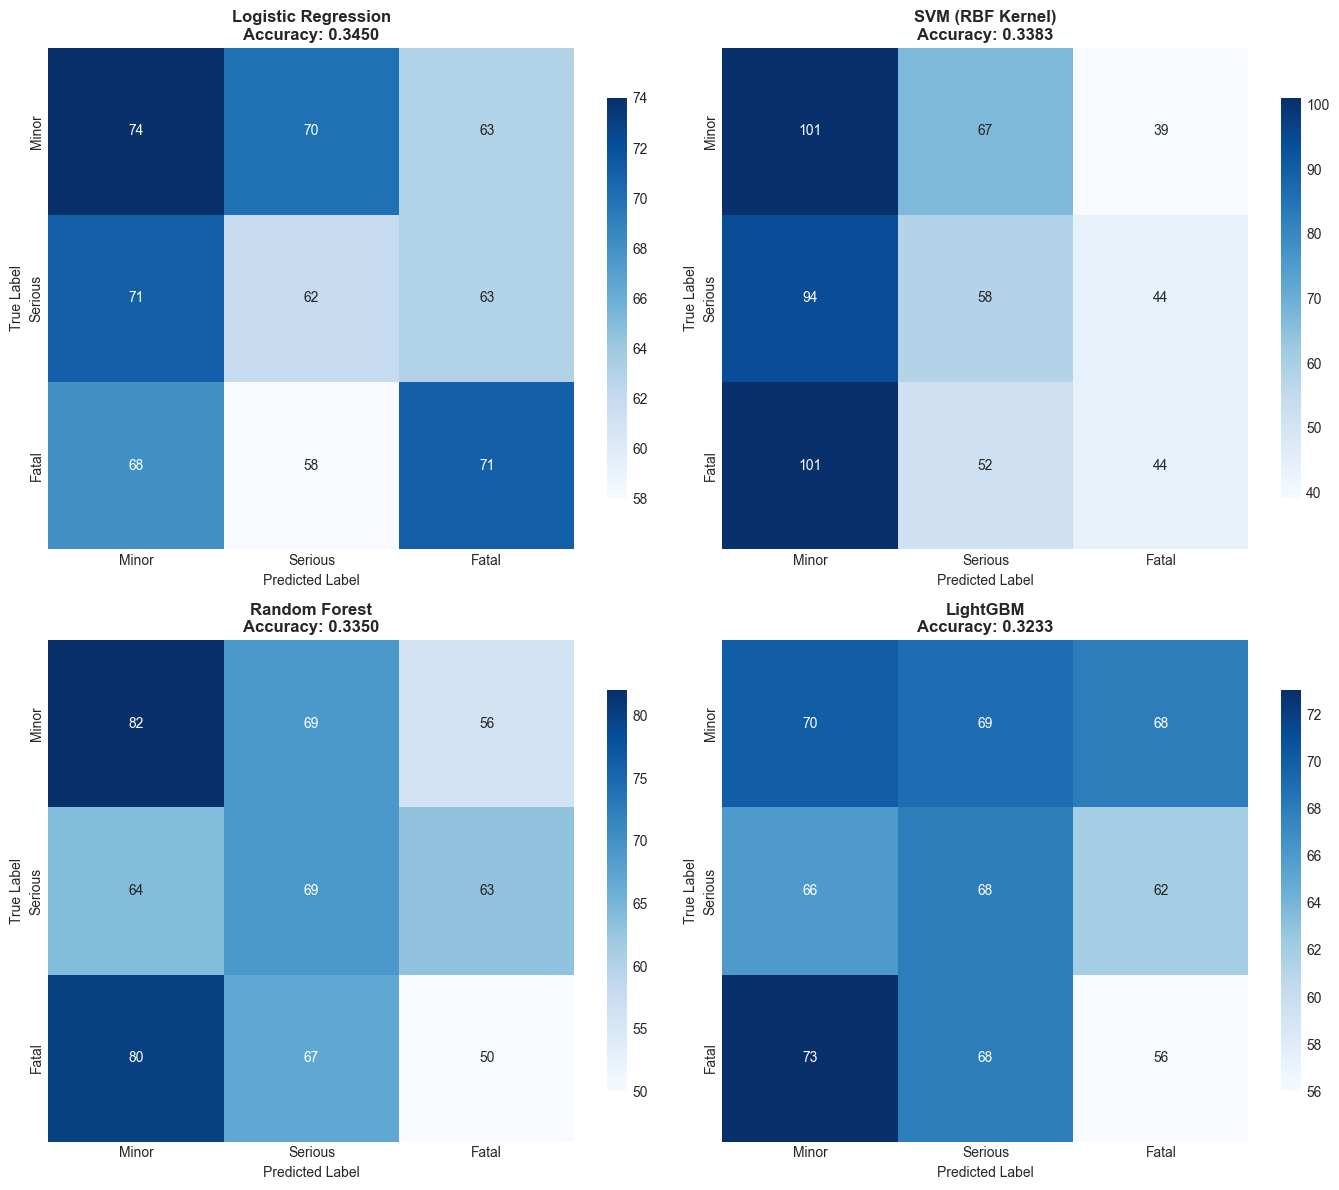


✓ Confusion matrices saved: confusion_matrices.png


In [17]:
# ============================================================================
# CELL 12: Confusion Matrices Visualization
# ============================================================================

print('='*80)
print('CONFUSION MATRICES')
print('='*80)

# Select top 4 models
top_models = comparison_df.head(4)['Model'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, model_name in enumerate(top_models):
    # Find results
    result = next(r for r in classification_results if r['Model'] == model_name)
    cm = result['Confusion_Matrix']
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Minor', 'Serious', 'Fatal'],
                yticklabels=['Minor', 'Serious', 'Fatal'],
                ax=axes[idx], cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'{model_name}\nAccuracy: {result["Test_Accuracy"]:.4f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Confusion matrices saved: confusion_matrices.png')
print('='*80)

FEATURE IMPORTANCE ANALYSIS

🌲 Top 20 Features (Random Forest):
                               Feature  Importance
                    Speed Limit (km/h)      0.1016
                            Driver Age      0.0983
                                  Hour      0.0839
           Number of Vehicles Involved      0.0472
                            Risk_Score      0.0349
                   Time_Period_Encoded      0.0341
              Driver_Age_Group_Encoded      0.0319
                Speed_Category_Encoded      0.0260
                 Driver Gender_Encoded      0.0242
                   High_Casualty_Count      0.0232
           Alcohol Involvement_Encoded      0.0218
              Lighting Conditions_Dusk      0.0177
                Multi_Vehicle_Accident      0.0173
                Road Type_Village Road      0.0167
                         Season_Spring      0.0162
                     High_Risk_Weather      0.0161
               Road Type_State Highway      0.0159
                  

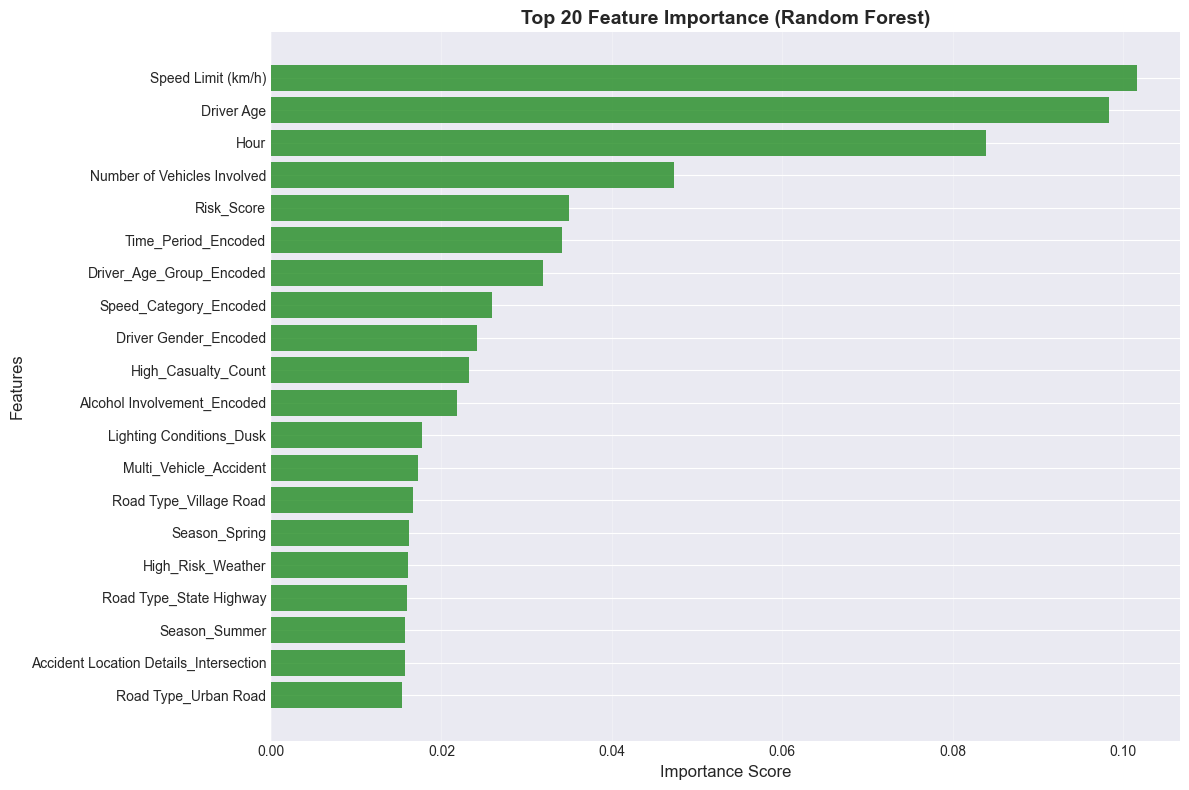


✓ Feature importance plot saved: feature_importance.png


In [18]:
# ============================================================================
# CELL 13: Feature Importance (Tree-based Models)
# ============================================================================

print('='*80)
print('FEATURE IMPORTANCE ANALYSIS')
print('='*80)

# Get feature importance from Random Forest
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_trained.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

print('\n🌲 Top 20 Features (Random Forest):')
print(rf_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='forestgreen', alpha=0.8)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Feature importance plot saved: feature_importance.png')
print('='*80)

---
## 📈 REGRESSION MODELS - CASUALTIES & FATALITIES PREDICTION
Predicting number of casualties and fatalities
---

In [20]:
# ============================================================================
# CELL 14: Helper Functions for Regression Models
# ============================================================================

def train_and_evaluate_regressor(model, model_name, X_train, y_train, X_test, y_test, target_name):
    """
    Train and evaluate a regression model
    """

    print(f'TRAINING: {model_name} - {target_name}')
    print('='*80)
    
    # Training
    start_time = time()
    model.fit(X_train, y_train)
    training_time = time() - start_time
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluation Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    
    print(f'\n✓ Training completed in {training_time:.2f} seconds')
    print(f'\n📊 Performance Metrics:')
    print(f'  • Training R² Score : {train_r2:.4f}')
    print(f'  • Test R² Score     : {test_r2:.4f}')
    print(f'  • MAE (Mean Abs Err): {mae:.4f}')
    print(f'  • MSE (Mean Sq Err) : {mse:.4f}')
    print(f'  • RMSE              : {rmse:.4f}')
    
    # Store results
    results = {
        'Model': model_name,
        'Target': target_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Training_Time': training_time,
        'Predictions': y_pred_test
    }
    
    return model, results

# Initialize results storage
regression_results = []

print('✓ Regression helper functions defined!')

✓ Regression helper functions defined!


In [21]:
# ============================================================================
# CELL 15: Regression Models - Casualties Prediction
# ============================================================================

print('='*80)
print('CASUALTIES PREDICTION MODELS')
print('='*80)

# Linear Regression
lr_reg = LinearRegression()
lr_reg_trained, lr_reg_results = train_and_evaluate_regressor(
    lr_reg, 'Linear Regression', 
    X_train, y_train_casualties, X_test, y_test_casualties, 'Casualties'
)
regression_results.append(lr_reg_results)
trained_models['Linear_Regression_Casualties'] = lr_reg_trained

# Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_reg_trained, rf_reg_results = train_and_evaluate_regressor(
    rf_reg, 'Random Forest Regressor', 
    X_train, y_train_casualties, X_test, y_test_casualties, 'Casualties'
)
regression_results.append(rf_reg_results)
trained_models['Random_Forest_Regressor_Casualties'] = rf_reg_trained

# XGBoost Regressor
xgb_reg = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_reg_trained, xgb_reg_results = train_and_evaluate_regressor(
    xgb_reg, 'XGBoost Regressor', 
    X_train, y_train_casualties, X_test, y_test_casualties, 'Casualties'
)
regression_results.append(xgb_reg_results)
trained_models['XGBoost_Regressor_Casualties'] = xgb_reg_trained

CASUALTIES PREDICTION MODELS
TRAINING: Linear Regression - Casualties

✓ Training completed in 0.02 seconds

📊 Performance Metrics:
  • Training R² Score : 0.0097
  • Test R² Score     : -0.0102
  • MAE (Mean Abs Err): 2.8420
  • MSE (Mean Sq Err) : 10.5682
  • RMSE              : 3.2509
TRAINING: Random Forest Regressor - Casualties

✓ Training completed in 0.36 seconds

📊 Performance Metrics:
  • Training R² Score : 0.8524
  • Test R² Score     : -0.0526
  • MAE (Mean Abs Err): 2.9088
  • MSE (Mean Sq Err) : 11.0117
  • RMSE              : 3.3184
TRAINING: XGBoost Regressor - Casualties

✓ Training completed in 0.25 seconds

📊 Performance Metrics:
  • Training R² Score : 0.9944
  • Test R² Score     : -0.1884
  • MAE (Mean Abs Err): 3.0106
  • MSE (Mean Sq Err) : 12.4322
  • RMSE              : 3.5259


In [22]:
# ============================================================================
# CELL 16: Regression Models - Fatalities Prediction
# ============================================================================

print('='*80)
print('FATALITIES PREDICTION MODELS')
print('='*80)

# Linear Regression
lr_reg_fatal = LinearRegression()
lr_reg_fatal_trained, lr_reg_fatal_results = train_and_evaluate_regressor(
    lr_reg_fatal, 'Linear Regression', 
    X_train, y_train_fatalities, X_test, y_test_fatalities, 'Fatalities'
)
regression_results.append(lr_reg_fatal_results)
trained_models['Linear_Regression_Fatalities'] = lr_reg_fatal_trained

# Random Forest Regressor
rf_reg_fatal = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_reg_fatal_trained, rf_reg_fatal_results = train_and_evaluate_regressor(
    rf_reg_fatal, 'Random Forest Regressor', 
    X_train, y_train_fatalities, X_test, y_test_fatalities, 'Fatalities'
)
regression_results.append(rf_reg_fatal_results)
trained_models['Random_Forest_Regressor_Fatalities'] = rf_reg_fatal_trained

# XGBoost Regressor
xgb_reg_fatal = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_reg_fatal_trained, xgb_reg_fatal_results = train_and_evaluate_regressor(
    xgb_reg_fatal, 'XGBoost Regressor', 
    X_train, y_train_fatalities, X_test, y_test_fatalities, 'Fatalities'
)
regression_results.append(xgb_reg_fatal_results)
trained_models['XGBoost_Regressor_Fatalities'] = xgb_reg_fatal_trained

FATALITIES PREDICTION MODELS
TRAINING: Linear Regression - Fatalities

✓ Training completed in 0.01 seconds

📊 Performance Metrics:
  • Training R² Score : 0.0107
  • Test R² Score     : -0.0120
  • MAE (Mean Abs Err): 1.5084
  • MSE (Mean Sq Err) : 3.0019
  • RMSE              : 1.7326
TRAINING: Random Forest Regressor - Fatalities

✓ Training completed in 0.35 seconds

📊 Performance Metrics:
  • Training R² Score : 0.8551
  • Test R² Score     : -0.0053
  • MAE (Mean Abs Err): 1.4907
  • MSE (Mean Sq Err) : 2.9821
  • RMSE              : 1.7269
TRAINING: XGBoost Regressor - Fatalities

✓ Training completed in 0.28 seconds

📊 Performance Metrics:
  • Training R² Score : 0.9957
  • Test R² Score     : -0.1108
  • MAE (Mean Abs Err): 1.5402
  • MSE (Mean Sq Err) : 3.2951
  • RMSE              : 1.8152


REGRESSION MODELS COMPARISON

📊 Casualties Prediction - Performance:
                  Model  Test_R2    MAE   RMSE
      Linear Regression  -0.0102 2.8420 3.2509
Random Forest Regressor  -0.0526 2.9088 3.3184
      XGBoost Regressor  -0.1884 3.0106 3.5259

📊 Fatalities Prediction - Performance:
                  Model  Test_R2    MAE   RMSE
      Linear Regression  -0.0120 1.5084 1.7326
Random Forest Regressor  -0.0053 1.4907 1.7269
      XGBoost Regressor  -0.1108 1.5402 1.8152


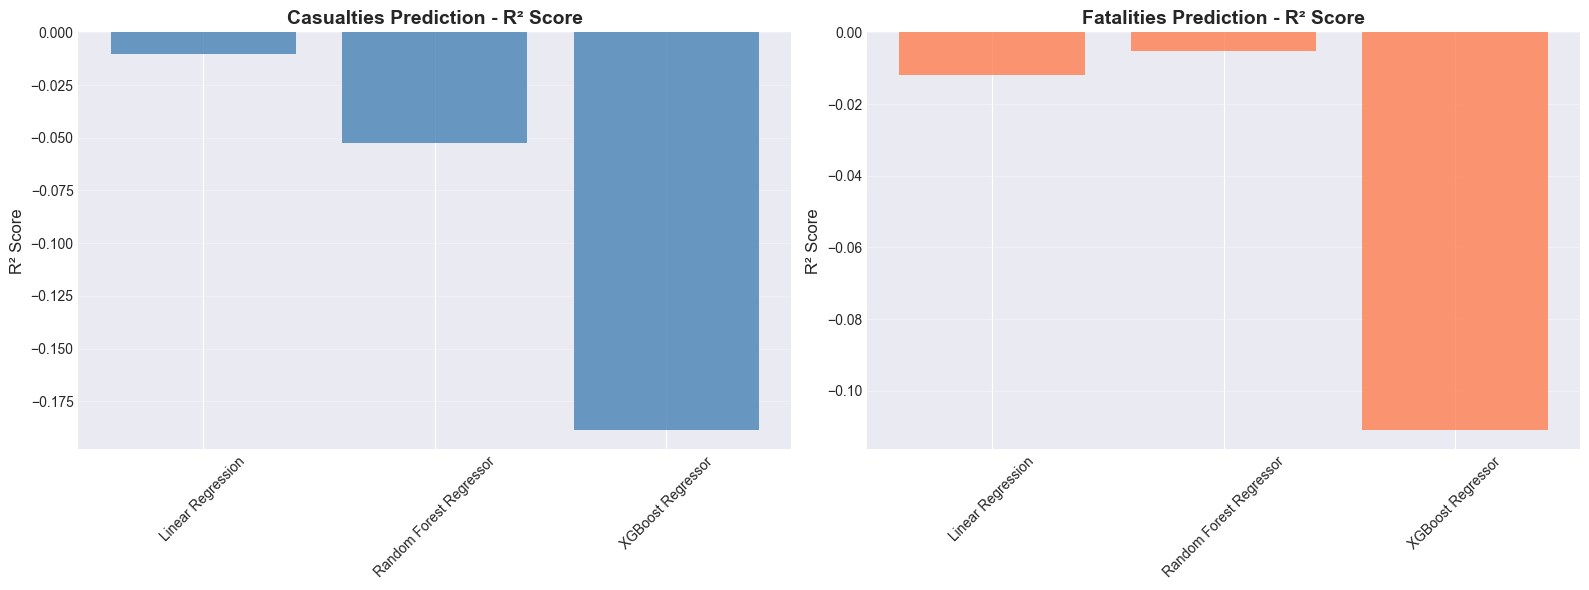


✓ Regression comparison saved: regression_comparison.png


In [23]:
# ============================================================================
# CELL 17: Regression Models Comparison
# ============================================================================

print('='*80)
print('REGRESSION MODELS COMPARISON')
print('='*80)

# Create comparison dataframe
regression_comparison = pd.DataFrame(regression_results)

# Separate by target
casualties_results = regression_comparison[regression_comparison['Target'] == 'Casualties']
fatalities_results = regression_comparison[regression_comparison['Target'] == 'Fatalities']

print('\n📊 Casualties Prediction - Performance:')
print(casualties_results[['Model', 'Test_R2', 'MAE', 'RMSE']].to_string(index=False))

print('\n📊 Fatalities Prediction - Performance:')
print(fatalities_results[['Model', 'Test_R2', 'MAE', 'RMSE']].to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Casualties
axes[0].bar(casualties_results['Model'], casualties_results['Test_R2'], 
            color='steelblue', alpha=0.8)
axes[0].set_title('Casualties Prediction - R² Score', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3, axis='y')

# Fatalities
axes[1].bar(fatalities_results['Model'], fatalities_results['Test_R2'], 
            color='coral', alpha=0.8)
axes[1].set_title('Fatalities Prediction - R² Score', fontsize=14, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Regression comparison saved: regression_comparison.png')
print('='*80)

---
## 💾 SAVE TRAINED MODELS
Export all trained models for deployment
---

In [24]:
# ============================================================================
# CELL 18: Save All Trained Models
# ============================================================================

print('='*80)
print('SAVING TRAINED MODELS')
print('='*80)

# Save each model
for model_name, model in trained_models.items():
    filename = f'{model_name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f'✓ Saved: {filename}')

# Save comparison results
comparison_df.to_csv('classification_results.csv', index=False)
regression_comparison.to_csv('regression_results.csv', index=False)

print(f'\n✓ All models saved successfully!')
print(f'  Total models saved: {len(trained_models)}')
print('  Classification results: classification_results.csv')
print('  Regression results: regression_results.csv')
print('='*80)

SAVING TRAINED MODELS
✓ Saved: Logistic_Regression.pkl
✓ Saved: Decision_Tree.pkl
✓ Saved: Random_Forest.pkl
✓ Saved: XGBoost.pkl
✓ Saved: LightGBM.pkl
✓ Saved: SVM.pkl
✓ Saved: KNN.pkl
✓ Saved: Linear_Regression_Casualties.pkl
✓ Saved: Random_Forest_Regressor_Casualties.pkl
✓ Saved: XGBoost_Regressor_Casualties.pkl
✓ Saved: Linear_Regression_Fatalities.pkl
✓ Saved: Random_Forest_Regressor_Fatalities.pkl
✓ Saved: XGBoost_Regressor_Fatalities.pkl

✓ All models saved successfully!
  Total models saved: 13
  Classification results: classification_results.csv
  Regression results: regression_results.csv


In [25]:
# ============================================================================
# CELL 19: Phase 4 Summary Report
# ============================================================================

print('='*80)
print('PHASE 4 SUMMARY REPORT: MODEL DEVELOPMENT & TRAINING')
print('='*80)

print('\n🎯 TASKS COMPLETED:')
print('-' * 80)

print('\n1. CLASSIFICATION MODELS TRAINED (7 models):')
print('  ✓ Logistic Regression')
print('  ✓ Decision Tree')
print('  ✓ Random Forest')
print('  ✓ XGBoost')
print('  ✓ LightGBM')
print('  ✓ Support Vector Machine (SVM)')
print('  ✓ K-Nearest Neighbors (KNN)')

print('\n2. REGRESSION MODELS TRAINED (6 models):')
print('  ✓ Linear Regression (Casualties)')
print('  ✓ Random Forest Regressor (Casualties)')
print('  ✓ XGBoost Regressor (Casualties)')
print('  ✓ Linear Regression (Fatalities)')
print('  ✓ Random Forest Regressor (Fatalities)')
print('  ✓ XGBoost Regressor (Fatalities)')

print('\n3. EVALUATION METRICS:')
print('  ✓ Classification: Accuracy, Precision, Recall, F1-Score')
print('  ✓ Regression: R², MAE, MSE, RMSE')
print('  ✓ Confusion matrices generated')
print('  ✓ Feature importance analyzed')

print('\n4. VISUALIZATIONS CREATED:')
print('  ✓ classification_comparison.png')
print('  ✓ confusion_matrices.png')
print('  ✓ feature_importance.png')
print('  ✓ regression_comparison.png')

print('\n5. MODELS SAVED:')
print(f'  ✓ {len(trained_models)} trained models exported as .pkl files')
print('  ✓ Results exported as CSV files')

print('\n' + '='*80)
print('📊 BEST MODELS IDENTIFIED:')
print('-' * 80)

# Classification
best_class_model = comparison_df.iloc[0]
print(f'\n🏆 Classification: {best_class_model["Model"]}')
print(f'   • Test Accuracy: {best_class_model["Test_Accuracy"]:.4f}')
print(f'   • F1-Score: {best_class_model["F1_Score"]:.4f}')

# Regression - Casualties
best_casualties = casualties_results.sort_values('Test_R2', ascending=False).iloc[0]
print(f'\n🏆 Casualties Prediction: {best_casualties["Model"]}')
print(f'   • R² Score: {best_casualties["Test_R2"]:.4f}')
print(f'   • RMSE: {best_casualties["RMSE"]:.4f}')

# Regression - Fatalities
best_fatalities = fatalities_results.sort_values('Test_R2', ascending=False).iloc[0]
print(f'\n🏆 Fatalities Prediction: {best_fatalities["Model"]}')
print(f'   • R² Score: {best_fatalities["Test_R2"]:.4f}')
print(f'   • RMSE: {best_fatalities["RMSE"]:.4f}')

print('\n✓ PHASE 4: MODEL DEVELOPMENT & TRAINING COMPLETED!')
print('='*80)
print('\n🚀 Ready for Phase 5: Deep Learning Models & Hyperparameter Tuning')
print('   Or proceed to Streamlit App Development!')

PHASE 4 SUMMARY REPORT: MODEL DEVELOPMENT & TRAINING

🎯 TASKS COMPLETED:
--------------------------------------------------------------------------------

1. CLASSIFICATION MODELS TRAINED (7 models):
  ✓ Logistic Regression
  ✓ Decision Tree
  ✓ Random Forest
  ✓ XGBoost
  ✓ LightGBM
  ✓ Support Vector Machine (SVM)
  ✓ K-Nearest Neighbors (KNN)

2. REGRESSION MODELS TRAINED (6 models):
  ✓ Linear Regression (Casualties)
  ✓ Random Forest Regressor (Casualties)
  ✓ XGBoost Regressor (Casualties)
  ✓ Linear Regression (Fatalities)
  ✓ Random Forest Regressor (Fatalities)
  ✓ XGBoost Regressor (Fatalities)

3. EVALUATION METRICS:
  ✓ Classification: Accuracy, Precision, Recall, F1-Score
  ✓ Regression: R², MAE, MSE, RMSE
  ✓ Confusion matrices generated
  ✓ Feature importance analyzed

4. VISUALIZATIONS CREATED:
  ✓ classification_comparison.png
  ✓ confusion_matrices.png
  ✓ feature_importance.png
  ✓ regression_comparison.png

5. MODELS SAVED:
  ✓ 13 trained models exported as .pkl fil